<a href="https://colab.research.google.com/github/koleshjr/Makerere-Fall-Army-worm-disease-detection/blob/main/fastai_winningsolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Setup FastAI and timm

In [1]:

# !pip install -U albumentations
# !pip install opencv-python==4.5.4.60
# !pip install -q --upgrade fastcore fastai
# !pip install timm==0.6.2.dev0




In [2]:
import random # just as the name implies, it's used for randomness
import numpy as np #numpy is numpy.......manages arrays
import gc #This is the garbage collector, I doubt we'll use it. i'm using colab pro
from pathlib import Path #path library manages path
import matplotlib.pyplot as plt #to plot basically
import pandas as pd #key library to manage your dataframe.

import albumentations
import timm

import fastai
from fastai.vision.all import * #import everthing from vision
print(fastai.__version__ )

2.7.7


## Load the files

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
 path = '/content/drive/MyDrive/Makere Armyworm/'

In [5]:
train_df = pd.read_csv(path + "Train(1).csv")
test_df = pd.read_csv(path + "Test.csv")
ss = pd.read_csv(path + "SampleSubmission.csv")


In [6]:
train_df.isnull().sum()

Image_id    0
Label       0
dtype: int64

## seed

In [7]:
#Seed everything for reproducibility
def random_seed(seed_value, use_cuda): 
    np.random.seed(seed_value)
 #cpu vars
    torch.manual_seed(seed_value) 
# cpu  vars
    random.seed(seed_value)
 # Python 
    if use_cuda: 
        torch.cuda.manual_seed(seed_value) 
        torch.cuda.manual_seed_all(seed_value) 
# gpu vars
        torch.backends.cudnn.deterministic = True 
 #needed
        torch.backends.cudnn.benchmark = False 
#Remember to use num_workers=0 when creating the DataBunch.

In [8]:
random_seed(2022,True)

In [9]:
train_df.head()

,Image_id,Label
0,id_02amazy34fgh2.jpg,1
1,id_02mh3w48pmyc9.jpg,0
2,id_02rpb463h9d3w.jpg,0
3,id_02wc3jeeao8ol.jpg,1
4,id_03t2hapb8wz8p.jpg,1


In [10]:
train_df.Image_id    = [path+"images/"+i for i in train_df.Image_id]

In [11]:
train_df.head()

,Image_id,Label
0,/content/drive/MyDrive/Makere Armyworm/images/id_02amazy34fgh2.jpg,1
1,/content/drive/MyDrive/Makere Armyworm/images/id_02mh3w48pmyc9.jpg,0
2,/content/drive/MyDrive/Makere Armyworm/images/id_02rpb463h9d3w.jpg,0
3,/content/drive/MyDrive/Makere Armyworm/images/id_02wc3jeeao8ol.jpg,1
4,/content/drive/MyDrive/Makere Armyworm/images/id_03t2hapb8wz8p.jpg,1


In [12]:
#Not an imbalanced dataset phewks
train_df.Label.value_counts()

0    810
1    809
Name: Label, dtype: int64


## Correct some wrong labels. - Didn't make use of it

In [13]:
issues = [
# ("/content/Images/ImageID_2OK3T60A.jpg", "Church"),
# ("/content/Images/ImageID_TSDTGVSP.jpg","Church"),

]



In [14]:
#Rename labels
for x,y in issues:
  train_df.loc[train_df['Image_id'] == x, 'Label'] = y

In [15]:
#Track rubbish labels
train_df.loc[train_df['Label'] == ""].index.values.tolist()

[]

In [16]:
#Drop them from the DataFrame.
train_df = train_df.drop(train_df.loc[train_df['Label'] == ""].index.values.tolist(), axis = 0).reset_index(drop=True)

In [17]:
train_df.shape

(1619, 2)

In [18]:
#Check new label distribution since you've edited.
train_df.Label.value_counts()

0    810
1    809
Name: Label, dtype: int64

In [19]:
#check the size of one image, it'll give you a sense of what you are about to resize
Image.open(path + 'images/id_00exusbkgzw1b.jpg').size

(765, 1024)

## Albumentations

In [20]:
class AlbumentationsTransform (RandTransform):
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [21]:
def get_train_aug(): return albumentations.Compose([
            albumentations.RandomResizedCrop(384, 384), #Extra tip, use size that's suitable for the efficentNetwork you are using.
            albumentations.CenterCrop(384,384),

            albumentations.RandomRotate90(),
            albumentations.Rotate(limit=(-90, 90)),
            albumentations.Transpose(),
            albumentations.RandomGamma(),
            albumentations.Blur(),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
            ], p=1.)



def get_valid_aug(): return albumentations.Compose([
            albumentations.Resize(384, 384),
            ], p=1.0)

item_tfms = AlbumentationsTransform(get_train_aug(), get_valid_aug())
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

## DATABLOCK

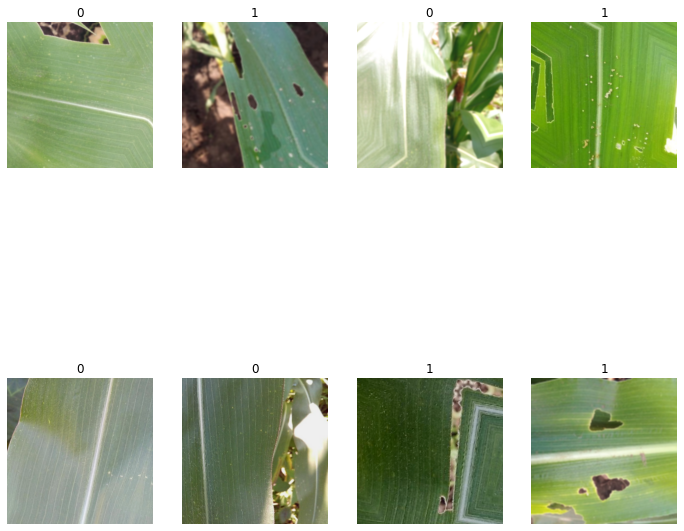

In [22]:

blocks = (ImageBlock, CategoryBlock)
splitter = TrainTestSplitter(0.1, stratify=train_df["Label"])
block = DataBlock(blocks = blocks,
                 get_x=ColReader(0),
                 get_y=ColReader(1),
                 splitter = splitter,
                 item_tfms = item_tfms,
                 batch_tfms = batch_tfms)
dls = block.dataloaders(train_df, bs=8)
dls.show_batch(figsize=(12,12))

In [23]:
timm.list_models('vit*')

['vit_base_patch8_224',
 'vit_base_patch8_224_dino',
 'vit_base_patch8_224_in21k',
 'vit_base_patch16_18x2_224',
 'vit_base_patch16_224',
 'vit_base_patch16_224_dino',
 'vit_base_patch16_224_in21k',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_224_miil_in21k',
 'vit_base_patch16_224_sam',
 'vit_base_patch16_384',
 'vit_base_patch16_plus_240',
 'vit_base_patch16_rpn_224',
 'vit_base_patch32_224',
 'vit_base_patch32_224_in21k',
 'vit_base_patch32_224_sam',
 'vit_base_patch32_384',
 'vit_base_patch32_plus_256',
 'vit_base_r26_s32_224',
 'vit_base_r50_s16_224',
 'vit_base_r50_s16_224_in21k',
 'vit_base_r50_s16_384',
 'vit_base_resnet26d_224',
 'vit_base_resnet50_224_in21k',
 'vit_base_resnet50_384',
 'vit_base_resnet50d_224',
 'vit_giant_patch14_224',
 'vit_gigantic_patch14_224',
 'vit_huge_patch14_224',
 'vit_huge_patch14_224_in21k',
 'vit_large_patch14_224',
 'vit_large_patch16_224',
 'vit_large_patch16_224_in21k',
 'vit_large_patch16_384',
 'vit_large_patch32_224',
 'vit_large_patch

## MODEL 1:  vit_base_patch16_384

In [24]:
roc = RocAucBinary()
learn = vision_learner(dls,"vit_base_patch16_384", loss_func=CrossEntropyLossFlat(),metrics=[accuracy, error_rate, roc]) 
learn.to_fp16()

In [25]:
# del variables
gc.collect()

15365

SuggestedLRs(valley=0.002511886414140463)

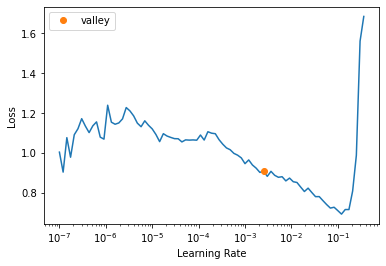

In [26]:
learn.lr_find()

In [27]:
learn.fine_tune(11,0.005248074419796467, freeze_epochs=1,cbs=[GradientAccumulation(), SaveModelCallback()]) 

epoch,train_loss,valid_loss,accuracy,error_rate,roc_auc_score,time
0,0.331801,0.099829,0.962963,0.037037,0.997257,06:49


Better model found at epoch 0 with valid_loss value: 0.0998290479183197.


epoch,train_loss,valid_loss,accuracy,error_rate,roc_auc_score,time
0,0.269630,0.019663,0.993827,0.006173,0.999848,01:44
1,0.293472,0.015720,0.993827,0.006173,1.000000,01:43
2,0.204551,0.034866,0.987654,0.012346,1.000000,01:43
3,0.193068,0.006583,1.000000,0.000000,1.000000,01:43
4,0.152814,0.003168,1.000000,0.000000,1.000000,01:43
5,0.106011,0.002089,1.000000,0.000000,1.000000,01:43
6,0.087979,0.007444,1.000000,0.000000,1.000000,01:43
7,0.119937,0.000651,1.000000,0.000000,1.000000,01:43
8,0.129432,0.004226,1.000000,0.000000,1.000000,01:43
9,0.090978,0.005070,1.000000,0.000000,1.000000,01:43


Better model found at epoch 0 with valid_loss value: 0.019663045182824135.
Better model found at epoch 1 with valid_loss value: 0.01571979559957981.
Better model found at epoch 3 with valid_loss value: 0.006583482958376408.
Better model found at epoch 4 with valid_loss value: 0.0031680376268923283.
Better model found at epoch 5 with valid_loss value: 0.0020887237042188644.
Better model found at epoch 7 with valid_loss value: 0.0006508207879960537.


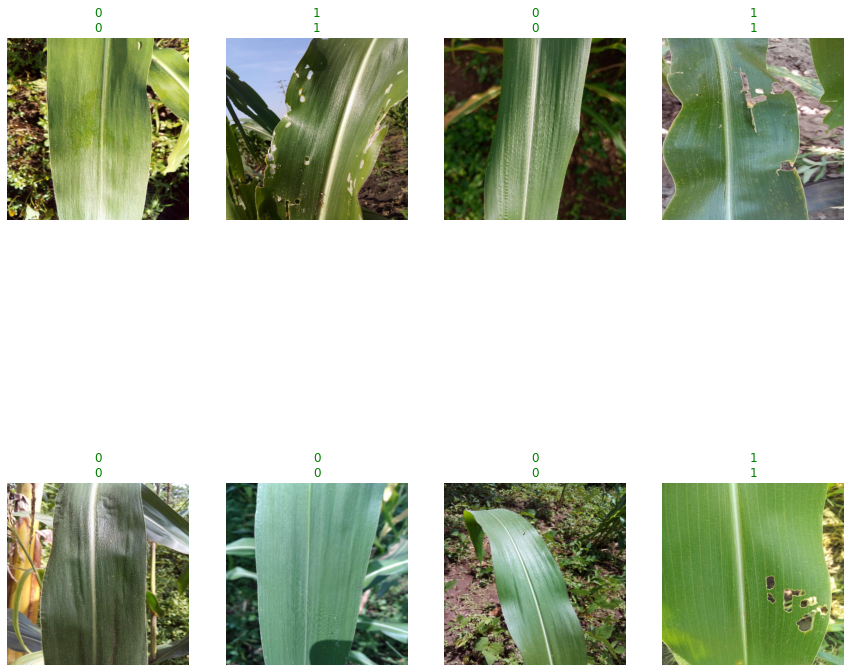

In [28]:
learn.show_results(figsize=(15,15))

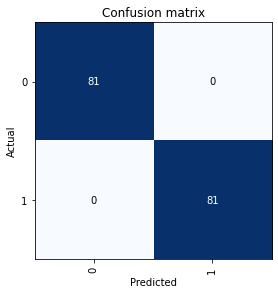

In [29]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

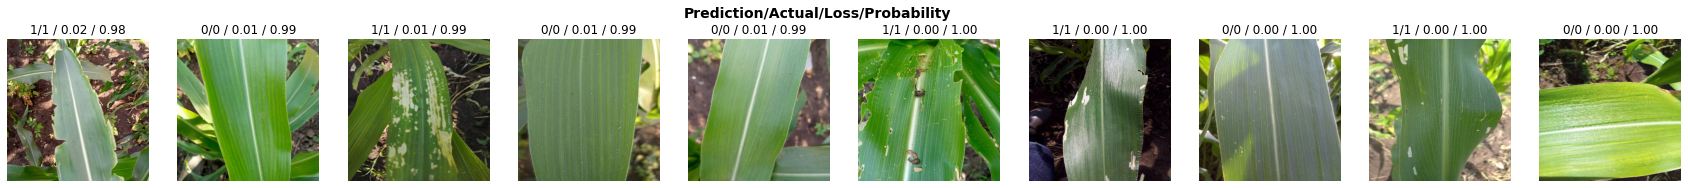

In [30]:
interp.plot_top_losses(10,nrows=1)

In [31]:
learn.to_fp32()
learn.save(path + 'vit_base_patch16_384')

Path('/content/drive/MyDrive/Makere Armyworm/vit_base_patch16_384.pth')

## Inference

In [32]:
sub = pd.read_csv(path + 'SampleSubmission.csv')


sample_df = sub.copy()


sample_df['Image_id'] = path + "images/" + sample_df['Image_id']

sample_df.head()

,Image_id,Label
0,/content/drive/MyDrive/Makere Armyworm/images/id_00exusbkgzw1b.jpg,0
1,/content/drive/MyDrive/Makere Armyworm/images/id_03dqinf6w0znv.jpg,0
2,/content/drive/MyDrive/Makere Armyworm/images/id_046yl0cxn3ybz.jpg,0
3,/content/drive/MyDrive/Makere Armyworm/images/id_04athdtx2abyg.jpg,0
4,/content/drive/MyDrive/Makere Armyworm/images/id_062aauf9e9jk0.jpg,0


In [33]:
test_dl = learn.dls.test_dl(sample_df)
preds, _ = learn.tta(dl=test_dl, n=10)
preds[:,1]
predictions = preds[:,1]
sample = test_df
sample.loc[:, "Label"] = predictions
sample.to_csv(path + "vit_base_patch16_384.csv", index=False)
sample.head()

,Image_id,Label
0,id_00exusbkgzw1b.jpg,0.000462
1,id_03dqinf6w0znv.jpg,0.000571
2,id_046yl0cxn3ybz.jpg,0.999726
3,id_04athdtx2abyg.jpg,0.001987
4,id_062aauf9e9jk0.jpg,0.002971


In [34]:
# del variables
gc.collect()
del learn